# Getting Started

Let's find out the basic usage cases for the **netallocation** package! 

You can install the package via [pypi](https://pypi.org/project/netallocation/) with
    
```
pip install netallocation
```

and run this notebook locally on your computer. 

In [1]:
import netallocation as ntl
import matplotlib.pyplot as plt

We want to have a look at a small *toy* pypsa network

In [2]:
n = ntl.test.get_network_ac_dc()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:pypsa.io:Imported network ac_dc.h5 has buses, carriers, generators, global_constraints, lines, links, loads


This network has the following N = 9 buses:

In [3]:
n.buses

,v_nom,carrier,x,y,control,generator,type,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
name,,,,,,,,,,,
London,380.0,AC,-0.13,51.50,PQ,,,1.0,0.0,inf,
Norwich,380.0,AC,1.30,52.60,PQ,,,1.0,0.0,inf,
Norwich DC,200.0,DC,1.30,52.50,Slack,,,1.0,0.0,inf,
Manchester,380.0,AC,-2.20,53.47,Slack,Manchester Wind,,1.0,0.0,inf,
Bremen,380.0,AC,8.80,53.08,PQ,,,1.0,0.0,inf,
Bremen DC,200.0,DC,8.80,52.98,PQ,,,1.0,0.0,inf,
Frankfurt,380.0,AC,8.70,50.12,Slack,Frankfurt Wind,,1.0,0.0,inf,
Norway,380.0,AC,10.75,60.00,Slack,Norway Wind,,1.0,0.0,inf,
Norway DC,200.0,DC,10.75,60.00,PQ,,,1.0,0.0,inf,


and L = 11 branches

In [4]:
ntl.utils.check_carriers(n)
n.branches()[['bus0', 'bus1', 'carrier']]

bus0        bus1 carrier
component name                                             
Line      0                      London  Manchester      AC
          1                  Manchester     Norwich      AC
          2                   Bremen DC  Norwich DC      DC
          3                  Norwich DC   Norway DC      DC
          4                   Norway DC   Bremen DC      DC
          5                     Norwich      London      AC
          6                      Bremen   Frankfurt      AC
Link      Norwich Converter     Norwich  Norwich DC      AC
          Norway Converter       Norway   Norway DC      AC
          Bremen Converter       Bremen   Bremen DC      AC
          DC link                London      Bremen      AC

The network consists of 3 passive DC and 7 passive AC lines, there is one controllable HVDC link from London to Bremen. The **capacities**, **dispatch** and **flow** of the network is already optimized, let's see how the network looks like: 

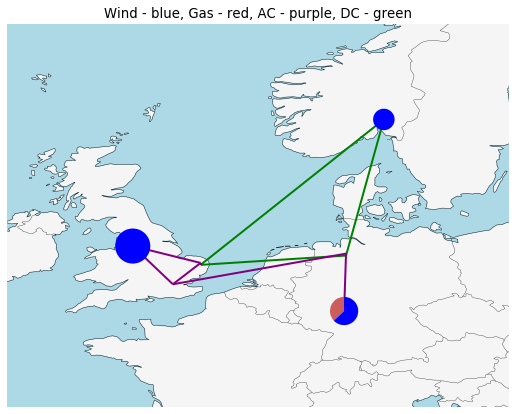

In [13]:
plot_kwargs = dict(line_colors=n.branches().carrier.map({'DC': 'green', 'AC': 'purple'}), color_geomap=True)

fig = plt.figure(figsize=(9,9))
n.plot(bus_sizes=n.generators.groupby(['bus', 'carrier']).p_nom_opt.sum()/5e3, margin=.5, 
       title='Wind - blue, Gas - red, AC - purple, DC - green', **plot_kwargs);

# Allocating Flows

Let's have a closer look at the **first** snapshot

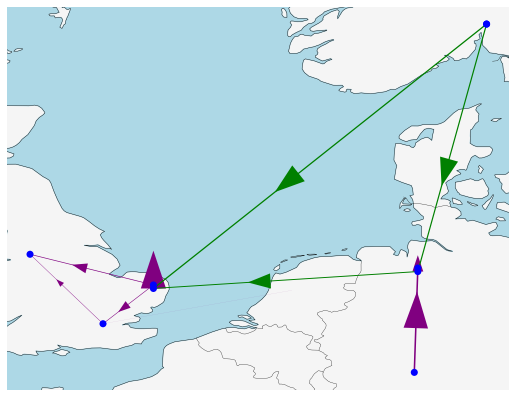

In [46]:
sn = n.snapshots[0]
fig = plt.figure(figsize=(9,9))
n.plot(flow=sn, line_widths={'Line':.1, 'Link':.1}, **plot_kwargs);

We are interested in the flow originating from the bus in **Norway**. Which way does is flow through the network? Where does its power flow to? 

Therefore we **allocate** the flow using the *flow tracing* (Average participation) method using the function `allocate_flow()`

In [47]:
ap = ntl.allocate_flow(n, snapshots=sn, method='Average participation')
ap

<xarray.Dataset>
Dimensions:                 (branch: 11, sink: 9, source: 9)
Coordinates:
  * source                  (source) object 'London' 'Norwich' ... 'Norway DC'
  * sink                    (sink) object 'London' 'Norwich' ... 'Norway DC'
    snapshot                datetime64[ns] 2015-01-01
  * branch                  (branch) MultiIndex
  - component               (branch) object 'Line' 'Line' ... 'Link' 'Link'
  - branch_i                (branch) object '0' '1' ... 'DC link'
Data variables:
    peer_to_peer            (sink, source) float64 0.0 0.0 0.0 ... 1.023e-12 0.0
    peer_on_branch_to_peer  (branch, source, sink) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    method:   Average Participation

There are two variables, `peer_to_peer` of dimension **source** $\times$ **sink** and `peer_on_branch_to_peer` of dimension **branch** $\times$ **source** $\times$ **sink**. With the first one, we can have look where **Norway** delivers power.

In [48]:
ap.peer_to_peer.sel(source='Norway').to_series()[lambda ds: abs(ds)>=1e-7]

sink
London         35.796244
Norwich       415.462564
Manchester    115.568453
Bremen        105.745518
Norway        820.035836
Name: peer_to_peer, dtype: float64

With the second we can trace the flow originating from **Norway**:

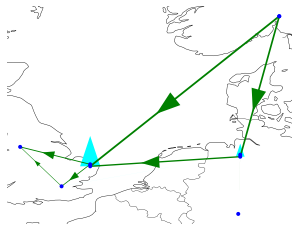

In [49]:
flow = ap.peer_on_branch_to_peer.sel(source='Norway').sum('sink')
n.plot(flow=flow.to_series()/10);

Is this concistent with the `P2P` allocation? This can be checked by summing over all power flowing into a bus (Incidence matrix!) 

In [50]:
(ntl.Incidence(n) @ flow).to_series()[lambda ds: abs(ds)>=1e-7]

bus
London        -35.796244
Norwich      -415.462564
Manchester   -115.568453
Bremen       -105.745518
Norway        672.572779
dtype: float64

# Allocating $CO_2$-emissions

In [59]:
co2_allocation = ntl.cost.weight_with_carrier_attribute(n, 'ap', attr='co2_emissions')

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO:netallocation.breakdown:Expanding by source carrier


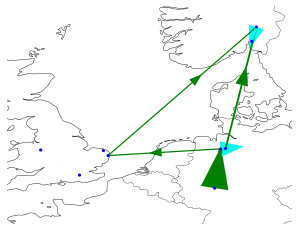

In [71]:
co2_flow = co2_allocation.peer_on_branch_to_peer.sum(['snapshot', 'source', 'sink', 'source_carrier'])
n.plot(flow = co2_flow.to_series(), jitter=.7, margin=.2, title='Average CO2 flow');